In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

In [2]:
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

### Building the Portfolio using ML filtering

In [3]:
from src.config import DATA_DIR
from src.momentum_strategy import get_J_returns, rank_stocks, get_winner_loser_masks
from src.portfolio import compute_portfolio_returns

In [4]:
path1 = DATA_DIR / "processed" / "monthly_returns.csv"
if not path1.exists():
        raise FileNotFoundError(f"Portfolio data not found at {path1}. Run returns.py first.")
else:
    monthly_returns = pd.read_csv(
        path1, 
        parse_dates=["Date"]
        ).set_index("Date")
    

In [5]:
ml_scores = pd.read_csv(
    DATA_DIR / "processed" / "ml_scores_J6_K6.csv", 
    parse_dates=["Date"]).set_index("Date")

In [6]:
ml_scores.index

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
      

In [ ]:
formation_returns = get_J_returns(6)
deciles = rank_stocks(formation_returns)
winners, losers = get_winner_loser_masks(deciles)


In [8]:
returns_base = compute_portfolio_returns(
    monthly_returns=monthly_returns,
    winners=winners,
    losers=losers,
    J=6,
    K=6
)
returns_base

,winner,loser,spread
Date,,,
2018-01-01,0.132143,-0.002339,0.134482
2018-02-01,0.005862,-0.084761,0.090623
2018-03-01,0.006434,-0.010199,0.016633
2018-04-01,0.020884,-0.001128,0.022011
2018-05-01,0.085310,0.005306,0.080003
...,...,...,...
2023-02-01,-0.001600,-0.023419,0.021819
2023-03-01,0.014712,0.032006,-0.017294
2023-04-01,0.012778,-0.013280,0.026057


In [9]:
formation_returns.index

DatetimeIndex(['2000-02-01', '2000-03-01', '2000-04-01', '2000-05-01',
               '2000-06-01', '2000-07-01', '2000-08-01', '2000-09-01',
               '2000-10-01', '2000-11-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=287, freq=None)

In [10]:
# align all objects
dates = formation_returns.index.intersection(ml_scores.index)
stocks = formation_returns.columns.intersection(ml_scores.columns)

formation_returns = formation_returns.loc[dates, stocks]
ml_scores = ml_scores.loc[dates, stocks]
winners = winners.loc[dates, stocks]
losers = losers.loc[dates, stocks]

In [11]:
def ml_filter_deciles(winners, losers, ml_scores, keep_frac=0.5):
    winners_ml = winners.copy() * False
    losers_ml = losers.copy() * False

    for t in winners.index:
        scores_t = ml_scores.loc[t]

        #winners filtering
        w_mask = winners.loc[t]
        w_scores = scores_t[w_mask]

        if len(w_scores) > 0:
            cutoff = w_scores.quantile(1 - keep_frac)
            keep = w_scores >= cutoff
            winners_ml.loc[t, keep.index] = keep

        #losers
        l_mask = losers.loc[t]
        l_scores = scores_t[l_mask]

        if len(l_scores) > 0:
            cutoff = l_scores.quantile(keep_frac)
            keep = l_scores <= cutoff
            losers_ml.loc[t, keep.index] = keep

    return winners_ml, losers_ml


In [12]:
winners_ml, losers_ml = ml_filter_deciles(
    winners, losers, ml_scores, keep_frac=0.5
)

In [13]:
common_stocks = (
    monthly_returns.columns
    .intersection(winners_ml.columns)
    .intersection(losers_ml.columns)
)

monthly_returns = monthly_returns[common_stocks]
winners_ml = winners_ml[common_stocks]
losers_ml = losers_ml[common_stocks]

In [14]:
returns_base.head()

,winner,loser,spread
Date,,,
2018-01-01,0.132143,-0.002339,0.134482
2018-02-01,0.005862,-0.084761,0.090623
2018-03-01,0.006434,-0.010199,0.016633
2018-04-01,0.020884,-0.001128,0.022011
2018-05-01,0.085310,0.005306,0.080003


In [15]:
returns_ml = compute_portfolio_returns(
    monthly_returns=monthly_returns,
    winners=winners_ml,
    losers=losers_ml,
    J=6,
    K=6
)
returns_ml.head()

,winner,loser,spread
Date,,,
2018-01-01,0.164957,-0.026998,0.191955
2018-02-01,0.011585,-0.080368,0.091952
2018-03-01,0.001436,-0.008079,0.009515
2018-04-01,0.018219,-0.017525,0.035744
2018-05-01,0.110839,0.003634,0.107204


In [16]:
returns_base["spread"].describe()

count    66.000000
mean      0.020800
std       0.056086
min      -0.142118
25%      -0.010734
50%       0.020261
75%       0.053238
max       0.162559
Name: spread, dtype: float64

In [17]:
returns_ml["spread"].describe()

count    66.000000
mean      0.029526
std       0.057415
min      -0.074736
25%      -0.002389
50%       0.026117
75%       0.059824
max       0.200089
Name: spread, dtype: float64

### Portfolio Evaluation

In [18]:
from src.capm_reg import capm_regression
from src.ff3_reg import ff3_reg
from src.risk_metrics import cumulative_returns, max_drawdown, sharpe_ratio, drawdown_series, skewness, annualized_volatility
from src.config import DATA_DIR

#### 1. CAPM

In [19]:
path2 = DATA_DIR / "portfolio" / "market_returns.csv"
if not path2.exists():
    raise FileNotFoundError(f"Risk-free rate data not found at {path2}. Run capm_params.py first.")
else:
    market = pd.read_csv(
        path2,
        parse_dates=["Date"]
        ).set_index("Date")["Market_Returns"]

In [20]:
path3 = DATA_DIR / "portfolio" /"rf_rate.csv"
if not path3.exists():
    raise FileNotFoundError(f"Risk-free rate data not found at {path3}. Run capm_params.py first.")
else:
    rf = pd.read_csv(
        path3,
        parse_dates=["Date"]
    ).set_index("Date")["Rf_Rate"]

In [21]:
capm_baseline = pd.concat(
    [returns_base, market, rf],
    axis=1
).dropna()

capm_ml = pd.concat(
    [returns_ml, market, rf],
    axis=1
).dropna()

In [22]:
winner = capm_ml["winner"]
loser = capm_ml["loser"]
spread = capm_ml["spread"]
market = capm_ml["Market_Returns"]
rf = capm_ml["Rf_Rate"]

In [23]:
capm_winner = capm_regression(
    portfolio_returns=winner,
    market_returns=market,
    risk_free_rate=rf
)

const    0.022452
Rm       1.192808
dtype: float64
Index(['const', 'Rm'], dtype='object')


In [24]:
capm_loser = capm_regression(
    portfolio_returns=loser,
    market_returns=market,
    risk_free_rate=rf
)

const   -0.007538
Rm       1.251792
dtype: float64
Index(['const', 'Rm'], dtype='object')


In [25]:
capm_strategy = capm_regression(
    portfolio_returns=spread,
    market_returns=market,
    risk_free_rate=rf
)

const    0.028746
Rm      -0.058517
dtype: float64
Index(['const', 'Rm'], dtype='object')


In [26]:
ml_capm_table = pd.DataFrame({
    "Winner": capm_winner,
    "Loser": capm_loser,
    "Winner-Loser": capm_strategy
}).T

ml_capm_table

,alpha,beta,t_alpha,t_beta,r_squared
Winner,0.022452,1.192808,4.009064,11.238042,0.663678
Loser,-0.007538,1.251792,-1.950648,17.090901,0.820275
Winner-Loser,0.028746,-0.058517,4.001254,-0.429772,0.002878


#### 2. FF3

In [27]:
path4 = DATA_DIR / "portfolio" / "ff3.csv"
if not path2.exists():
    raise FileNotFoundError(f"Risk-free rate data not found at {path4}. Run download_ff3s.py first.")
else:
    ff3_factors = pd.read_csv(
        path4,
        parse_dates=["Date"]
        ).set_index("Date")

In [28]:
ff3_df = pd.concat(
    [returns_ml, ff3_factors],
    axis=1
).dropna()

In [29]:
ff3_res = ff3_reg(
    portfolio_returns=ff3_df['spread'],
    ff_factors=ff3_df[['RM', 'SMB', 'HML', 'RF']]
)

ff3_res

const    0.027354
RM      -0.037930
SMB      0.088756
HML     -0.368699
dtype: float64
Index(['const', 'RM', 'SMB', 'HML'], dtype='object')


{'alpha': np.float64(0.02735447462025771),
 't_alpha': np.float64(3.8811619043007948),
 'beta_mkt': np.float64(-0.037929632924804196),
 'beta_smb': np.float64(0.08875588557394906),
 'beta_hml': np.float64(-0.3686988163198511),
 't_beta_mkt': np.float64(-0.28417842105402197),
 't_beta_smb': np.float64(0.34374983486201216),
 't_beta_hml': np.float64(-2.379717594241248),
 'r_squared': np.float64(0.0870399304025079)}

#### 3. Risk and Drawdown

In [30]:
import matplotlib.pyplot as plt

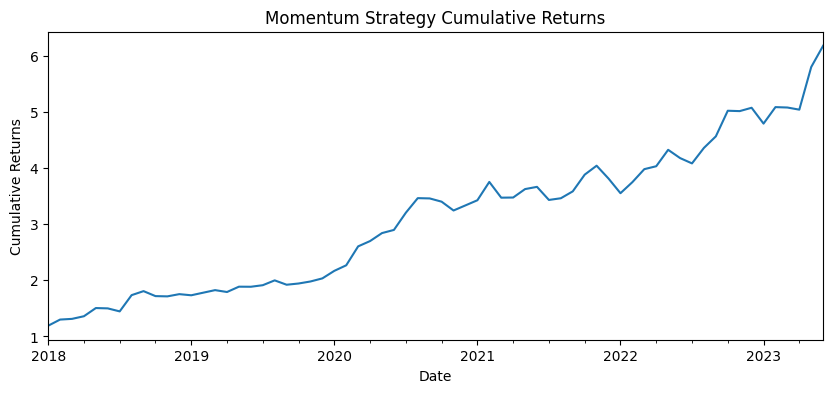

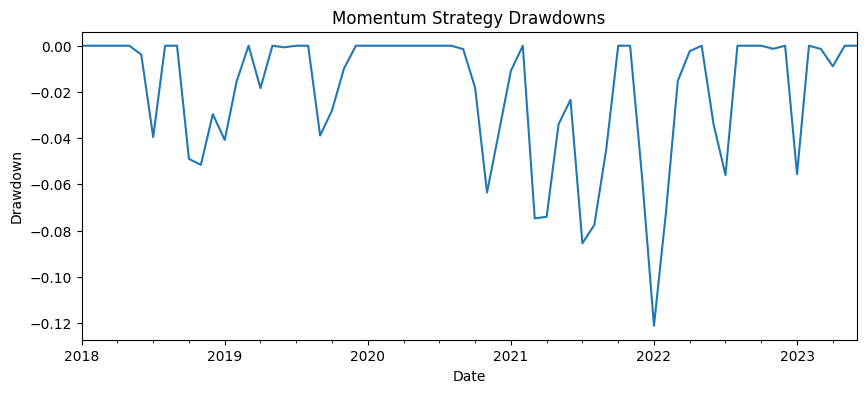

In [31]:
cum_ret = cumulative_returns(returns_ml['spread'])
dd = drawdown_series(cum_ret)
cum_ret.plot(figsize=(10, 4), title="Momentum Strategy Cumulative Returns")
plt.ylabel("Cumulative Returns")
plt.show()
dd.plot(figsize=(10, 4), title="Momentum Strategy Drawdowns")
plt.ylabel("Drawdown")
plt.show()

In [32]:
winner_returns = returns_ml['winner']
loser_returns = returns_ml['loser']
momentum_returns = returns_ml['spread']

In [33]:
market_sharpe = sharpe_ratio(market, rf)
print(f"Market Sharpe Ratio: {market_sharpe:.4f}")

Market Sharpe Ratio: 0.0433


In [34]:
metrics = {
    "Winner": {
        "Annualized Volatility": annualized_volatility(winner_returns),
        "Sharpe": sharpe_ratio(winner_returns, rf),
        "Max Drawdown": max_drawdown(winner_returns),
        "Skew": skewness(winner_returns)
    },
    "Loser": {
        "Annualized Volatility": annualized_volatility(loser_returns),
        "Sharpe": sharpe_ratio(loser_returns, rf),
        "Max Drawdown": max_drawdown(loser_returns),
        "Skew": skewness(loser_returns)
    },
    "Momentum (W-L)": {
        "Annualized Volatility": annualized_volatility(momentum_returns),
        "Sharpe": sharpe_ratio(momentum_returns, rf),
        "Max Drawdown": max_drawdown(momentum_returns),
        "Skew": skewness(momentum_returns)
    }
}

risk_table = pd.DataFrame(metrics).T
risk_table

,Annualized Volatility,Sharpe,Max Drawdown,Skew
Winner,0.266808,0.119457,-0.201206,0.156235
Loser,0.251660,0.009245,-0.375435,-0.401558
Momentum (W-L),0.198890,0.142380,-0.121175,0.714196
